In [1]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tools as smt
import statsmodels.stats.descriptivestats as std

## Read data
## Grouping M&A volume by month

In [2]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [3]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [4]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [5]:
"""Net M&A volume"""
net_vol_monthly = target_uk + acquirer_uk

In [6]:
# net_vol_monthly.index.values.astype(str)

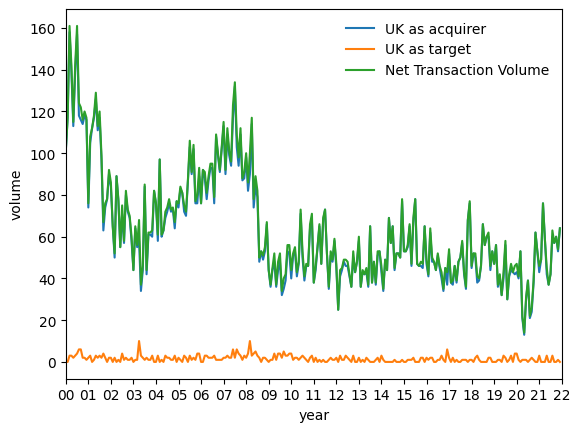

In [7]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## GDP

## Only quarterly data available

In [8]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
# gdp_quarter

In [9]:
"""Regrouping transactions by cumulative of 3 months and quarterly data of other explanatory variables: SMI, EXUSUK, and SMI."""
res = []
for i in range(int(len(net_vol_monthly)/3)):
    s = net_vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
# gdp_quarter

## Variables

In [10]:
until = '2022-01'
var_monthly = read_variable_monthly()
interest_rate = read_interest_rate()
interest_rate['Date'] = interest_rate['Date'].dt.to_period('M')
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]
interest_rate = interest_rate[interest_rate['Date'] < until]
var_monthly['vol'] = net_vol_monthly.vol.values
var_monthly['Interest_Rate'] = interest_rate['Interest_Rate']

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
# gdp_quarter
var_monthly

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2000-01,1.6404,5.8227,1335.808,101
1,2000-02,1.6000,5.6347,1201.506,117
2,2000-03,1.5799,5.3707,1188.530,161
3,2000-04,1.5823,5.3213,1232.977,142
4,2000-05,1.5090,5.4033,1181.588,115
...,...,...,...,...,...
259,2021-08,1.3797,0.6440,1154.280,63
260,2021-09,1.3732,0.8023,1150.933,57
261,2021-10,1.3701,1.0830,1113.011,60
262,2021-11,1.3463,0.9394,1167.690,54


# Main Regression (Before Brexit)

In [11]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI']
y_index = ['vol']

start_from = '2002-01'
data = var_monthly[var_monthly.Date >= start_from]
data.reset_index(inplace=True, drop=True)
sep = '2016-6'
data_before = data[data.Date < sep]
data_after = data[data.Date > sep]

"""Regressing on historical transactions between Aug.2001 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)

(0.6177649760945159, 0.2318908533369991)

In [12]:
model_before.coef_

array([[ 0.        , 22.12368281,  9.46650448,  0.03523657]])

In [13]:
data

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2002-01,1.4322,4.9171,962.025,86
1,2002-02,1.4227,4.9251,924.759,65
2,2002-03,1.4230,5.2202,927.846,52
3,2002-04,1.4429,5.2331,959.587,89
4,2002-05,1.4598,5.2689,946.755,78
...,...,...,...,...,...
235,2021-08,1.3797,0.6440,1154.280,63
236,2021-09,1.3732,0.8023,1150.933,57
237,2021-10,1.3701,1.0830,1113.011,60
238,2021-11,1.3463,0.9394,1167.690,54


To evaluate the influence of Brexit, which happened in June of 2016, we divide the historical dataset into two parts by the event of Brexit: `X_train` and `X_text` for variables, and `Y_train` and `Y_test` for M&A volume, respectively. For each dataset, the OLS is adopted to build the model. In other words, the model before Brexit, named `model_before` is trained by the dateset before 2016 June, i.e., `X_train`. Hence, the use of the trained model (`model_before`) with the given `X_test` yields its own prediction, called `Y_test_pred_model_before`,  that is assumed without the influence of Brexit. Finally, calculating the percentage error between `Y_test_pred_model_before` and `Y_test` is able to tell us how much the M&A volume is influenced by Brexit.

Of course, since we have `X_text` and `Y_test`, we are also able to run the OLS on it. Consequently, the model, called `model_after` is introduced, which should have the error mean close to zero by the OLS definition. Then we expect to see that the percentage error should be close to zero as well.

The cell below reconfigure the data to be able to process by the OLS. Also, the figure shows the OLS model, compared to the data.

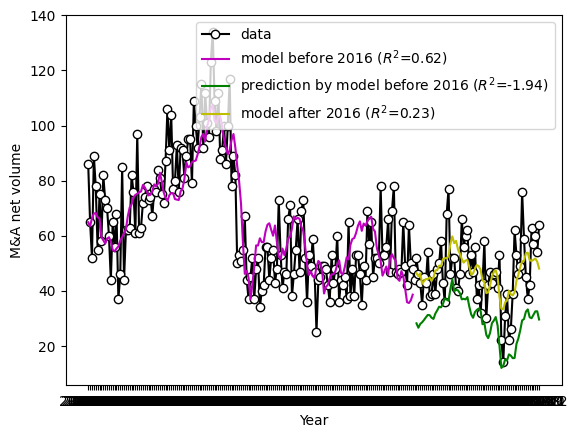

In [14]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2016 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

# ax.axvline(65, ls='--', color='gray')
# plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
# ax.set_xlim(0, 88)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

Instead of using the mean square error, we simply use the percentage error given as

$$
\text{ER} = \frac{Y_{test} - \hat{Y}_{test}^{before}}{Y_{test}}.
$$
This way we can learn the direction of the prediction, either over-estimation or under-estimation.

In [15]:
Y_test_pred_model_before = model_before.predict(X_test)
Y_test_pred_model_after = model_after.predict(X_test)

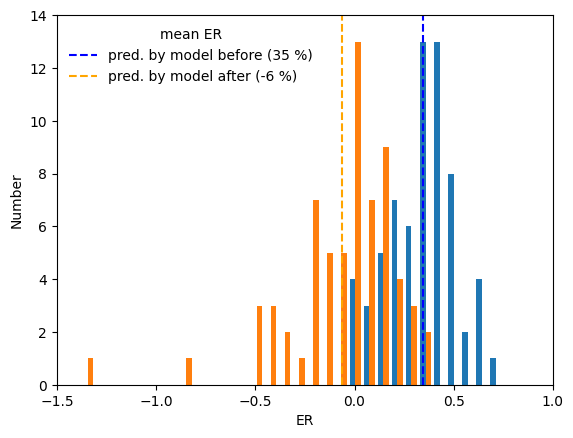

In [55]:
error_test_model_before = (Y_test - Y_test_pred_model_before) / Y_test
error_test_model_after = (Y_test - Y_test_pred_model_after) / Y_test
ax = plt.gca()

ax.hist([error_test_model_before.reshape(-1), error_test_model_after.reshape(-1)], bins=30)
ax.axvline(error_test_model_before.mean(), color='b', ls='--',
           label=f'pred. by model before ({round(error_test_model_before.mean()*100)} %)')
ax.axvline(error_test_model_after.mean(), color='orange', ls='--',
           label=f'pred. by model after ({round(error_test_model_after.mean()*100)} %)')

ax.set_xlabel('ER')
ax.set_ylabel('Number')
ax.set_xlim(-1.5, 1)
ax.set_ylim(0, 14)
ax.legend(frameon=False, title='mean ER')

The figure above shows that the `model_before` overestimates the M&A volume by 35%. it alternatively says that Brexit degraded the M&A volume by 35%.

In [17]:
mse_model_before = smt.eval_measures.mse(Y_test, Y_test_pred)
# mse_model_before
mse_model_after = smt.eval_measures.mse(Y_test, Y_test_pred_model_after)
mse_model_after
var_monthly

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2000-01,1.6404,5.8227,1335.808,101
1,2000-02,1.6000,5.6347,1201.506,117
2,2000-03,1.5799,5.3707,1188.530,161
3,2000-04,1.5823,5.3213,1232.977,142
4,2000-05,1.5090,5.4033,1181.588,115
...,...,...,...,...,...
259,2021-08,1.3797,0.6440,1154.280,63
260,2021-09,1.3732,0.8023,1150.933,57
261,2021-10,1.3701,1.0830,1113.011,60
262,2021-11,1.3463,0.9394,1167.690,54


## Model before announcement of Brexit

In [18]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.OLS(Y_train, X_train).fit()
multi_model_before.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     91.05
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           4.19e-35
Time:                        13:26:32   Log-Likelihood:                -694.33
No. Observations:                 173   AIC:                             1397.
Df Residuals:                     169   BIC:                             1409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -47.2305     12.210     -3.868      0.000     -71.334     -23.127
Spot_Rate        22.1237     12.956      1.708      0.090      -3.453      47.700
Interest_Rate     9.4665      1.425      6.641      0.000       6.653      12.280
SMI               0.0352      0.008      4.617      0.000       0.020       0.050
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.808
Skew:                           0.126   Prob(JB):                        0.405
Kurtosis:                       2.567   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


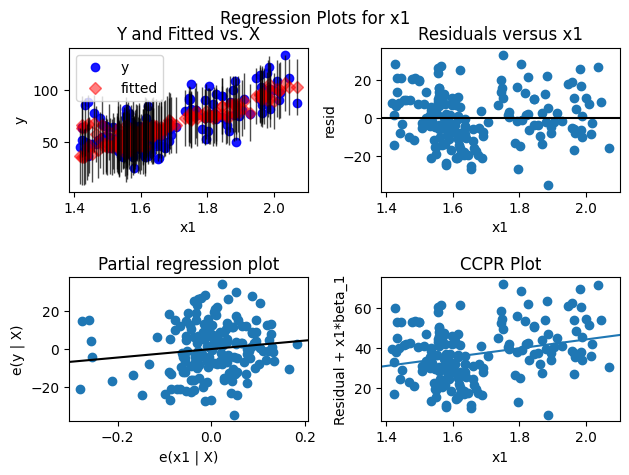

In [19]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

eval_env: 1


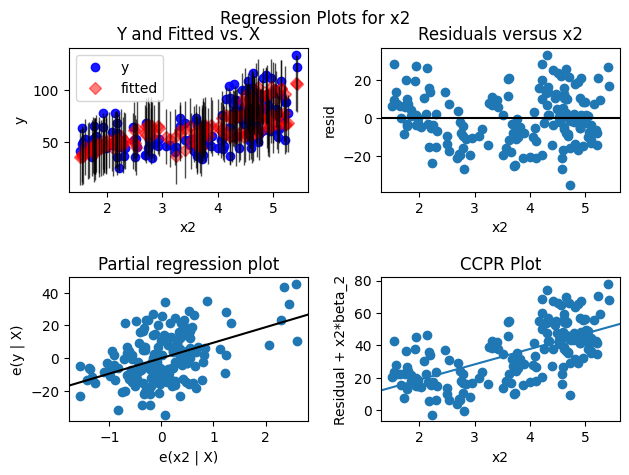

In [20]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

eval_env: 1


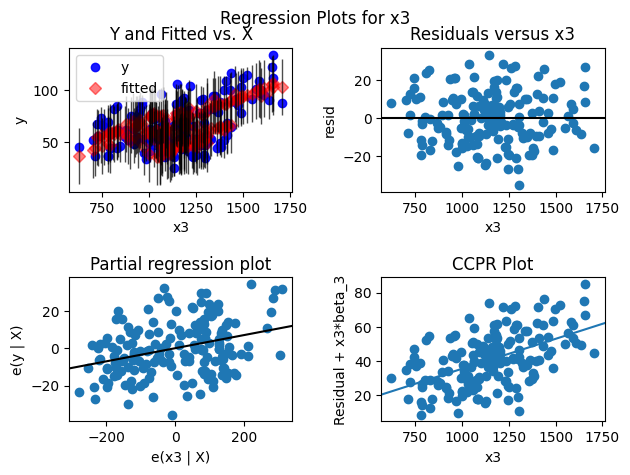

In [21]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

In [22]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     91.05
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           4.19e-35
Time:                        13:26:33   Log-Likelihood:                -694.33
No. Observations:                 173   AIC:                             1397.
Df Residuals:                     169   BIC:                             1409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.2305     12.210     -3.868      0.0

In [23]:
sm.add_constant(X_train)

array([[1.000000e+00, 1.432200e+00, 4.917100e+00, 9.620250e+02],
       [1.000000e+00, 1.422700e+00, 4.925100e+00, 9.247590e+02],
       [1.000000e+00, 1.423000e+00, 5.220200e+00, 9.278460e+02],
       [1.000000e+00, 1.442900e+00, 5.233100e+00, 9.595870e+02],
       [1.000000e+00, 1.459800e+00, 5.268900e+00, 9.467550e+02],
       [1.000000e+00, 1.483700e+00, 5.099000e+00, 9.327910e+02],
       [1.000000e+00, 1.556500e+00, 5.002700e+00, 9.009680e+02],
       [1.000000e+00, 1.536800e+00, 4.746000e+00, 7.894540e+02],
       [1.000000e+00, 1.556300e+00, 4.500600e+00, 8.113480e+02],
       [1.000000e+00, 1.557500e+00, 4.616000e+00, 7.440860e+02],
       [1.000000e+00, 1.571100e+00, 4.637800e+00, 7.791010e+02],
       [1.000000e+00, 1.586300e+00, 4.564400e+00, 8.062920e+02],
       [1.000000e+00, 1.617500e+00, 4.389900e+00, 7.910760e+02],
       [1.000000e+00, 1.607900e+00, 4.213100e+00, 7.562520e+02],
       [1.000000e+00, 1.582500e+00, 4.324300e+00, 7.273910e+02],
       [1.000000e+00, 1.5

In [24]:
multi_model_before.model.exog

array([[1.000000e+00, 1.432200e+00, 4.917100e+00, 9.620250e+02],
       [1.000000e+00, 1.422700e+00, 4.925100e+00, 9.247590e+02],
       [1.000000e+00, 1.423000e+00, 5.220200e+00, 9.278460e+02],
       [1.000000e+00, 1.442900e+00, 5.233100e+00, 9.595870e+02],
       [1.000000e+00, 1.459800e+00, 5.268900e+00, 9.467550e+02],
       [1.000000e+00, 1.483700e+00, 5.099000e+00, 9.327910e+02],
       [1.000000e+00, 1.556500e+00, 5.002700e+00, 9.009680e+02],
       [1.000000e+00, 1.536800e+00, 4.746000e+00, 7.894540e+02],
       [1.000000e+00, 1.556300e+00, 4.500600e+00, 8.113480e+02],
       [1.000000e+00, 1.557500e+00, 4.616000e+00, 7.440860e+02],
       [1.000000e+00, 1.571100e+00, 4.637800e+00, 7.791010e+02],
       [1.000000e+00, 1.586300e+00, 4.564400e+00, 8.062920e+02],
       [1.000000e+00, 1.617500e+00, 4.389900e+00, 7.910760e+02],
       [1.000000e+00, 1.607900e+00, 4.213100e+00, 7.562520e+02],
       [1.000000e+00, 1.582500e+00, 4.324300e+00, 7.273910e+02],
       [1.000000e+00, 1.5

In [25]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.983563537433142),
 ('p-value', 0.2632444494606156),
 ('f-value', 1.327725381657983),
 ('f p-value', 0.26707283180449193)]

In [26]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,4)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

,VIF
EXUSUK,4.470705
Interest_Rate,2.662402
SMI,2.821100


## Model after announcement of Brexit

In [27]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.239
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           0.000902
Time:                        13:26:34   Log-Likelihood:                -248.80
No. Observations:                  66   AIC:                             505.6
Df Residuals:                      62   BIC:                             514.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -63.3874     34.201     -1.853      0.069    -131.754       4.979
Spot_Rate        63.0748     29.620      2.129      0.037       3.866     122.284
Interest_Rate     5.3354      5.086      1.049      0.298      -4.832      15.503
SMI               0.0206      0.022      0.944      0.349      -0.023       0.064
==============================================================================
Omnibus:                        1.284   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.334
Skew:                           0.295   Prob(JB):                        0.513
Kurtosis:                       2.629   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""

name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_after.resid, multi_model_after.model.exog)
lzip(name_after, test_after)

[('Lagrange multiplier statistic', 5.122010708222389),
 ('p-value', 0.16307785346444986),
 ('f-value', 1.738803945422464),
 ('f p-value', 0.16828717852552538)]

In [29]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,4)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

,VIF
EXUSUK,1.296021
Interest_Rate,2.324752
SMI,2.746506


eval_env: 1


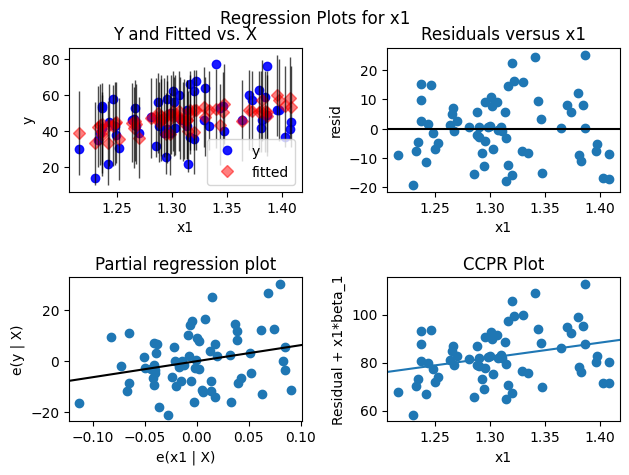

In [30]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

eval_env: 1


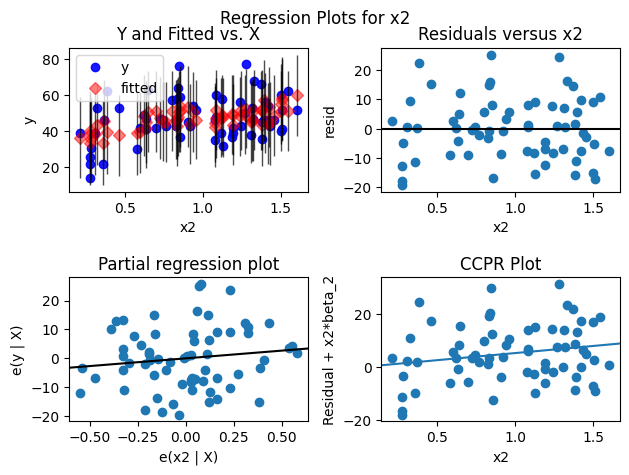

In [31]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

eval_env: 1


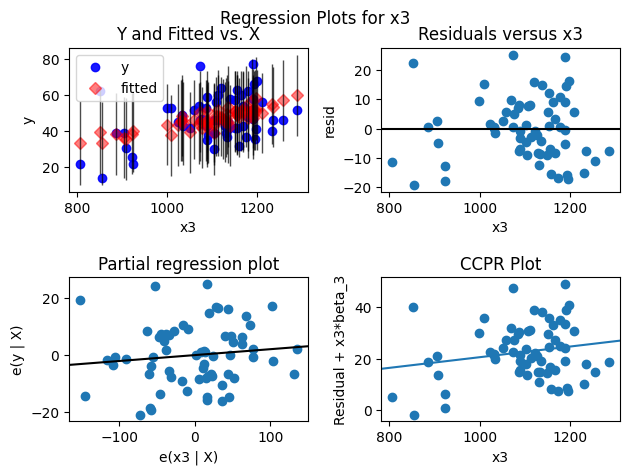

In [32]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

## Overall Model from 2002 to 2021

In [33]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary(xname=['Constant', 'Spot_Rate', 'Interest_Rate', 'SMI'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     81.83
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           7.52e-25
Time:                        13:26:35   Log-Likelihood:                -442.67
No. Observations:                  88   AIC:                             893.3
Df Residuals:                      84   BIC:                             903.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant         89.4257     35.960      2.487      0.015      17.915     160.936
Spot_Rate      -185.4171     34.958     -5.304      0.000    -254.934    -115.900
Interest_Rate    48.0594      3.883     12.377      0.000      40.337      55.781
SMI               0.2167      0.027      7.931      0.000       0.162       0.271
==============================================================================
Omnibus:                        0.707   Durbin-Watson:                   0.748
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.299
Skew:                           0.098   Prob(JB):                        0.861
Kurtosis:                       3.208   Cond. No.                     1.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.696940232769278),
 ('p-value', 0.19538210460306216),
 ('f-value', 1.5787454492670867),
 ('f p-value', 0.20058597580044968)]

In [35]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,4)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

,VIF
EXUSUK,3.279592
Interest_Rate,2.463071
SMI,1.669564


eval_env: 1


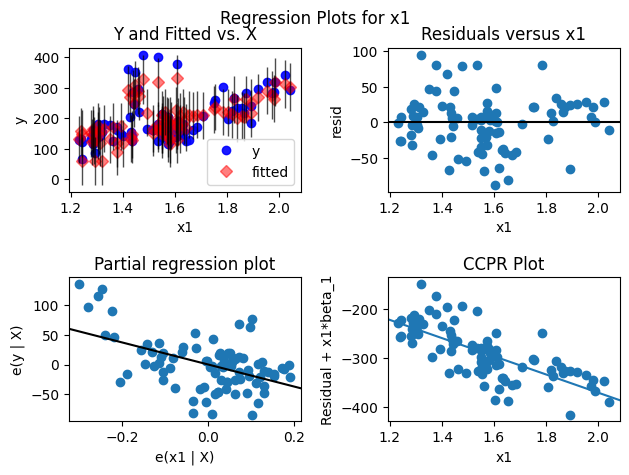

In [36]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

eval_env: 1


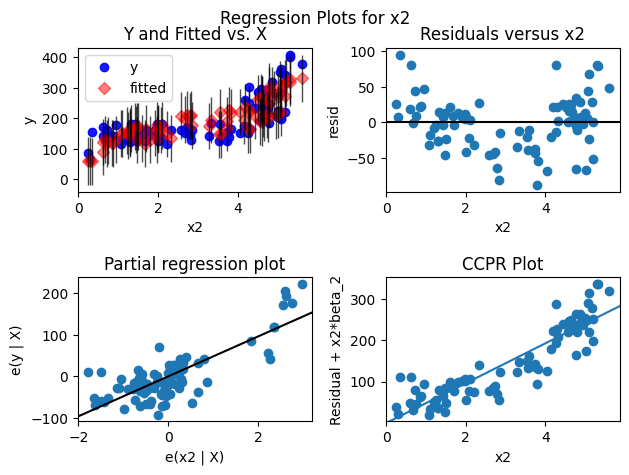

In [37]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

eval_env: 1


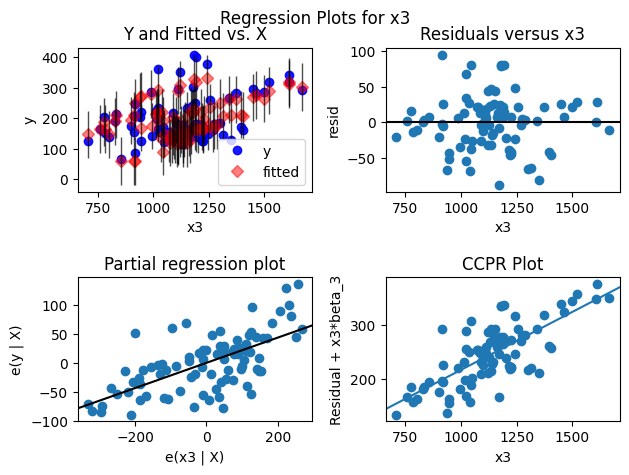

In [38]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [39]:
print(overall_model_ols.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     81.83
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           7.52e-25
Time:                        13:26:37   Log-Likelihood:                -442.67
No. Observations:                  88   AIC:                             893.3
Df Residuals:                      84   BIC:                             903.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.4257     35.960      2.487      0.0